# Oneshot using TripletSemiHardLoss function with Mnist dataset

This notebook follows https://www.tensorflow.org/addons/tutorials/losses_triplet tutorial.  

In [1]:
# import tensorflow as tf
# print('tf version:', tf.__version__)

In [2]:
# !pip install -q tensorflow_datasets
# !pip install -q --no-deps tensorflow-addons~=0.7

In [3]:
# import tensorflow_addons as tfa
# ImportError: This version of TensorFlow Addons requires TensorFlow version >= 2.1.0; 
# Detected an installation of version 2.0.0-rc1. Please upgrade TensorFlow to proceed.

In [4]:
import os
import io

import numpy as np
import tensorflow as tf

print('tf version:', tf.__version__)

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

# tf.keras.backend.set_image_data_format('channels_first')
np.random.seed(1234)
tf.random.set_seed(1234)
np.set_printoptions(threshold=8)
tf.keras.backend.set_image_data_format('channels_last')

%matplotlib inline
%load_ext autoreload
%autoreload 2


tf version: 2.1.0


## Prepare the Data

In [5]:
def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

train_dataset, test_dataset = tfds.load(name="mnist", split=['train', 'test'], as_supervised=True)

# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(32)
train_dataset = train_dataset.map(_normalize_img)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)

In [6]:
print(train_dataset)

<DatasetV1Adapter shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

## Train and Evaluate

In [8]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())


In [9]:
# Train the network
history = model.fit(
    train_dataset,
    epochs=5)

Epoch 1/5
1875/1875 [==============================] - 46s 25ms/step - loss: 0.4205
Epoch 2/5
1875/1875 [==============================] - 44s 23ms/step - loss: 0.2760
Epoch 3/5
1875/1875 [==============================] - 46s 24ms/step - loss: 0.2464
Epoch 4/5
1875/1875 [==============================] - 49s 26ms/step - loss: 0.2304
Epoch 5/5
1875/1875 [==============================] - 47s 25ms/step - loss: 0.2220


In [10]:
# Evaluate the network
results = model.predict(test_dataset)
print(results)

[[ 0.0240024  -0.07106676  0.08622828 ... -0.0684478   0.03128099
   0.02113042]
 [ 0.03039799 -0.02794076  0.0696959  ...  0.06913452 -0.06377928
   0.09678454]
 [-0.0215725  -0.00495127 -0.06315599 ...  0.08756582  0.0868606
  -0.01074688]
 ...
 [ 0.09513336  0.03698853  0.02155795 ...  0.04118683  0.06610469
  -0.00678524]
 [ 0.02689068 -0.00277288  0.07757588 ...  0.0553918  -0.069181
   0.08888192]
 [-0.05696702 -0.02936742 -0.00695095 ... -0.06149871 -0.01391023
  -0.04227653]]


In [11]:
# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()

try:
  from google.colab import files
  files.download('vecs.tsv')
  files.download('meta.tsv')
except:
  pass

## Embedding Projector

The vector and metadata files can be loaded and visualized here: https://projector.tensorflow.org/

You can see the results of our embedded test data when visualized with UMAP:

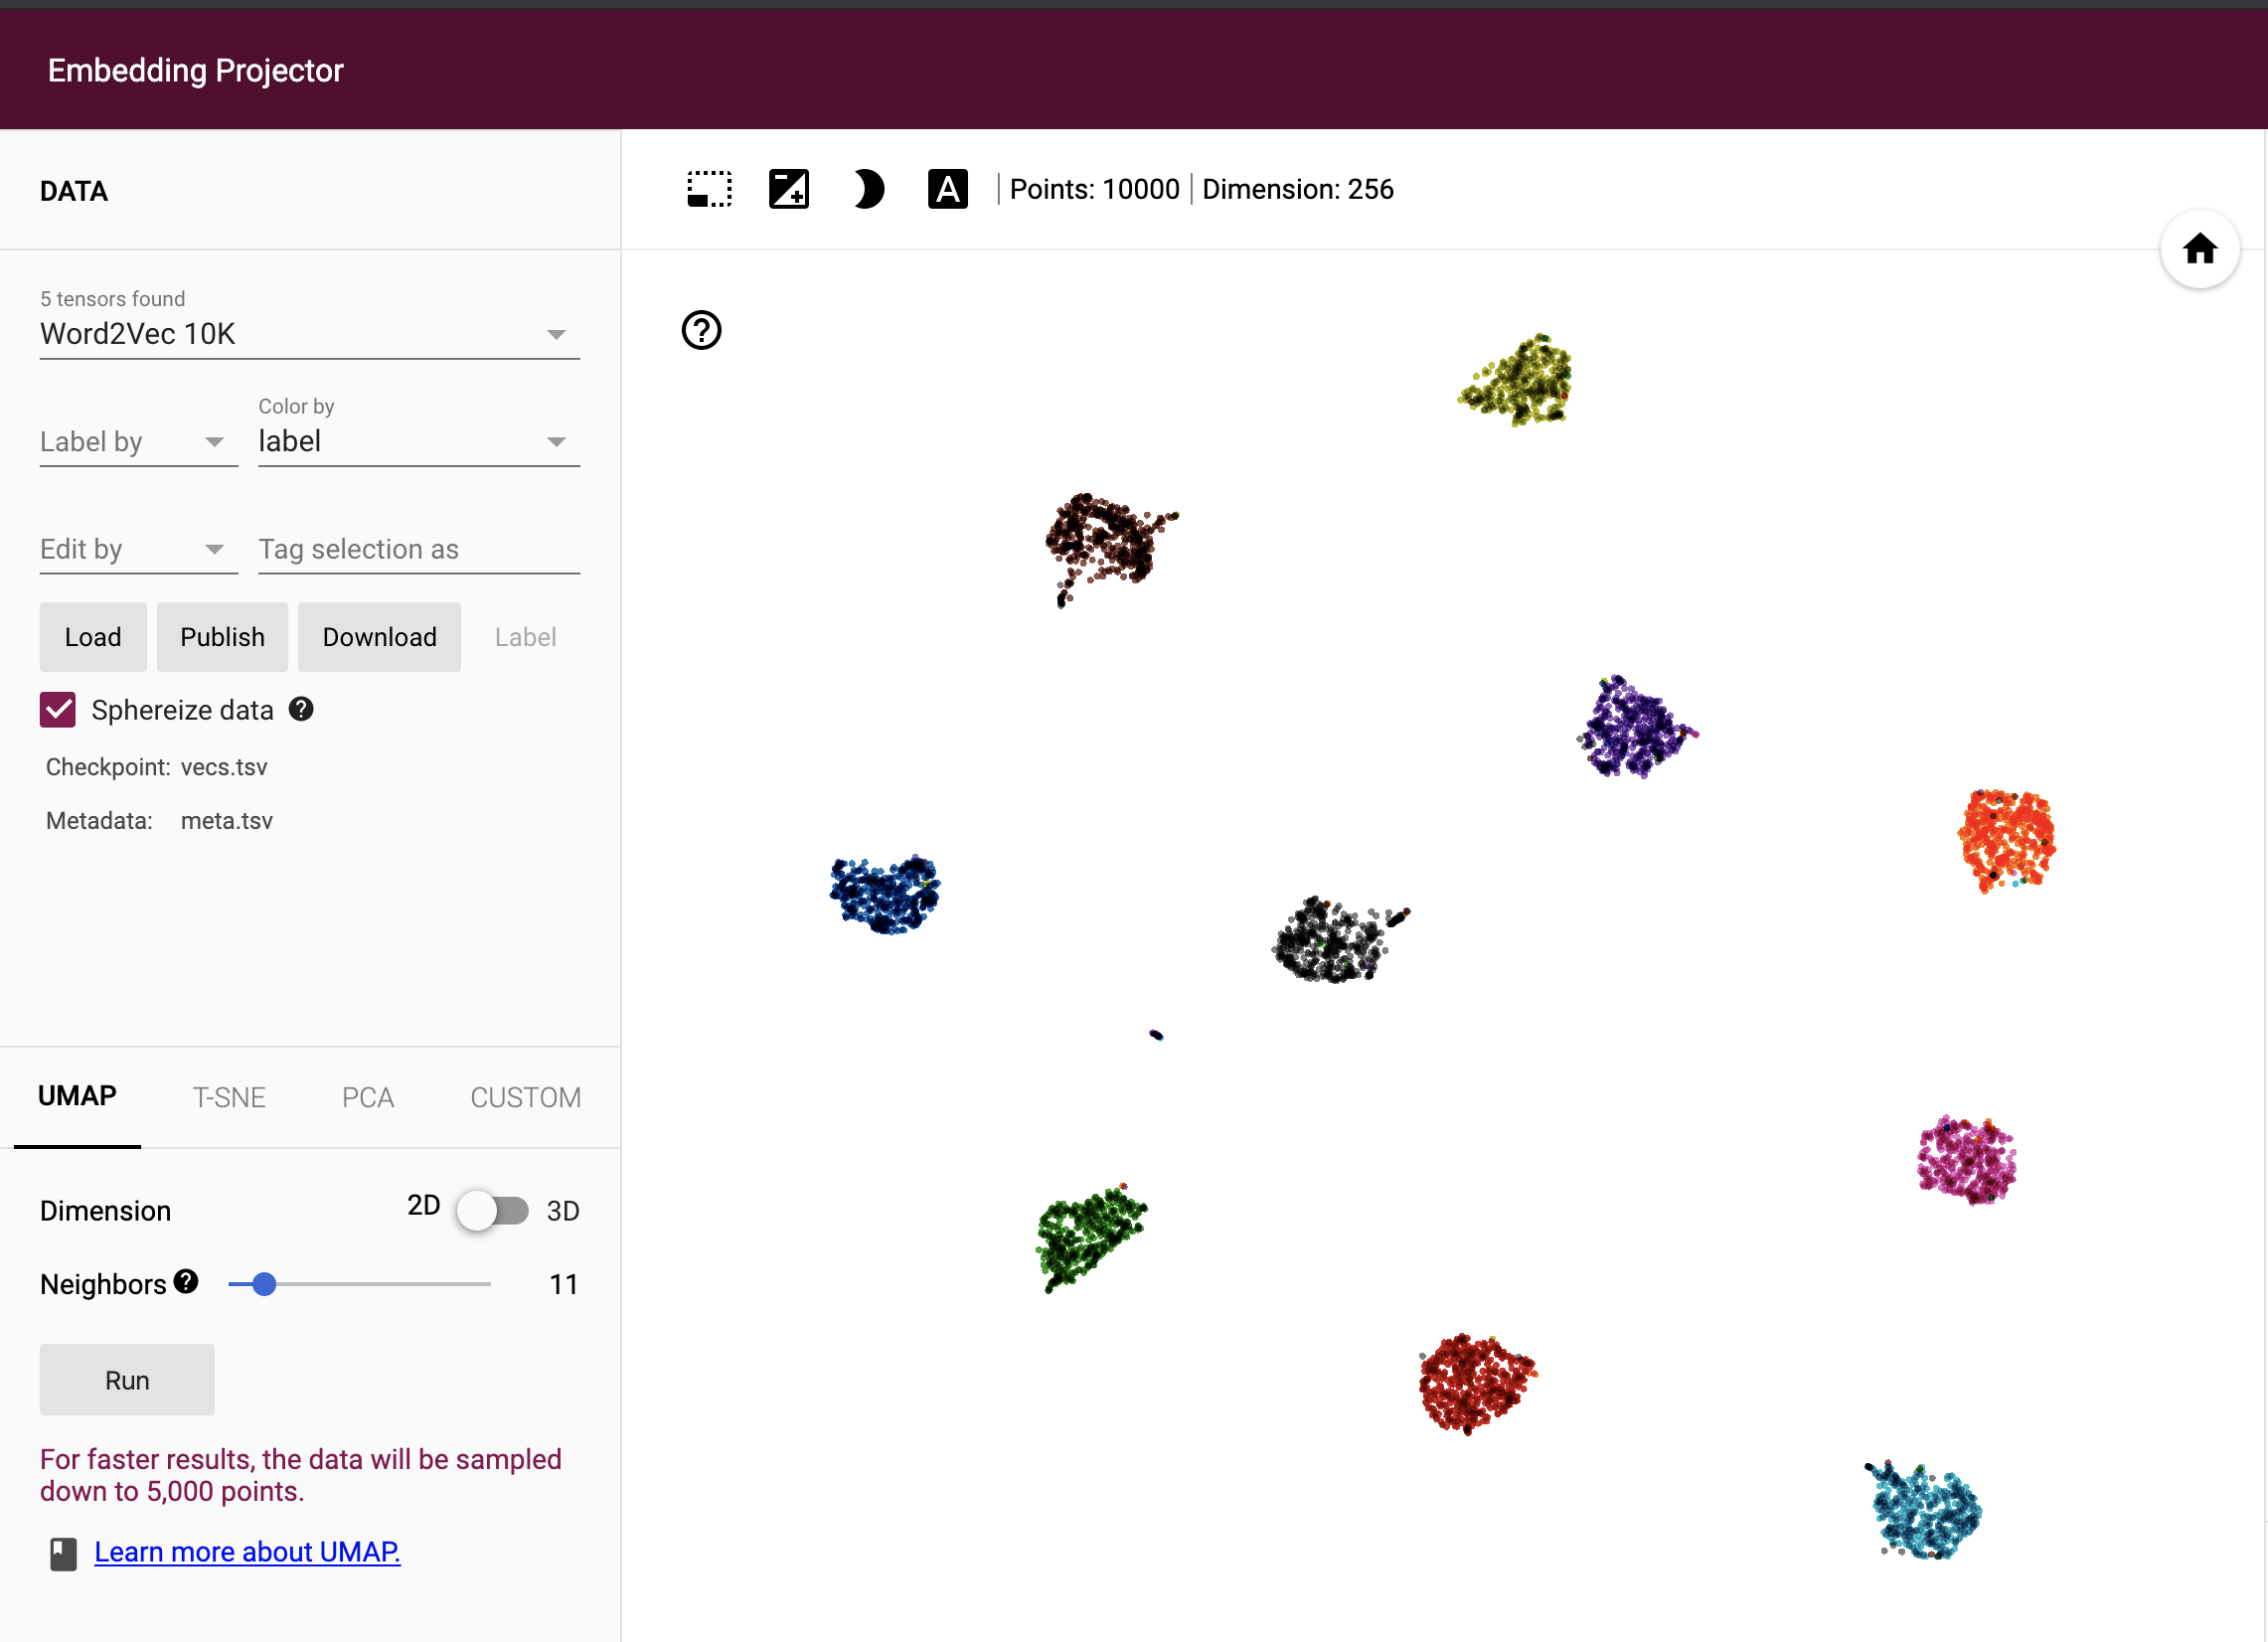